In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path


plt.style.use("default")
plt.rcParams.update({
    #"text.usetex": False,
    #"font.family": "serif",
    #"font.serif": ["Helvetica"],
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})

DATA_SOURCE = Path.cwd().parent / 'data' / 'input' / 'raw'
PROC_SOURCE = DATA_SOURCE.parent/ "processed"


In [17]:
ds = pd.read_pickle(PROC_SOURCE / "ten_materials.pkl.gz")
# ds = pd.read_pickle(PROC_SOURCE / "N49.pkl.gz")
full_b, full_h = ds.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), ds.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()

In [37]:
from utils.experiments import bool_filter_sine
t = np.arange(1024)
template_lbls = ['other', 'square', 'sawtooth', 'sine']

def get_waveform_est():
  
    # labels init all with 'other'
    k = np.zeros(full_b.shape[0], dtype=int)
    
    # square
    k[np.all(np.abs(full_b[:, 250:500:50] - full_b[:, 200:450:50]) / np.max(np.abs(full_b), axis=1).reshape(-1, 1) < 0.05, axis=1) & np.all(full_b[:, -200:]< 0, axis=1)] = 1
    
    # saw tooth
    B_max_idx = np.argmax(full_b, axis=1)
    k[B_max_idx >= 512] = 2 
    
    # sine
    k[bool_filter_sine(full_b, rel_kf=0.005, rel_kc=0.005)] = 3

    return k
        
ds["waveform"] = get_waveform_est()


waveform
0    120450
2     45612
1     13920
3      6765
Name: count, dtype: int64


Text(0.5, 1.0, 'Global waveform occurences')

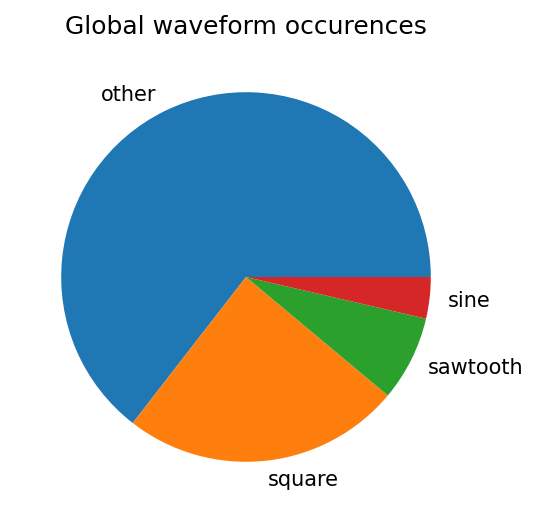

In [38]:
counts_per_waveform = ds['waveform'].value_counts()
print(counts_per_waveform)
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.pie(counts_per_waveform.to_numpy().ravel(), labels=template_lbls)
ax.set_title("Global waveform occurences")

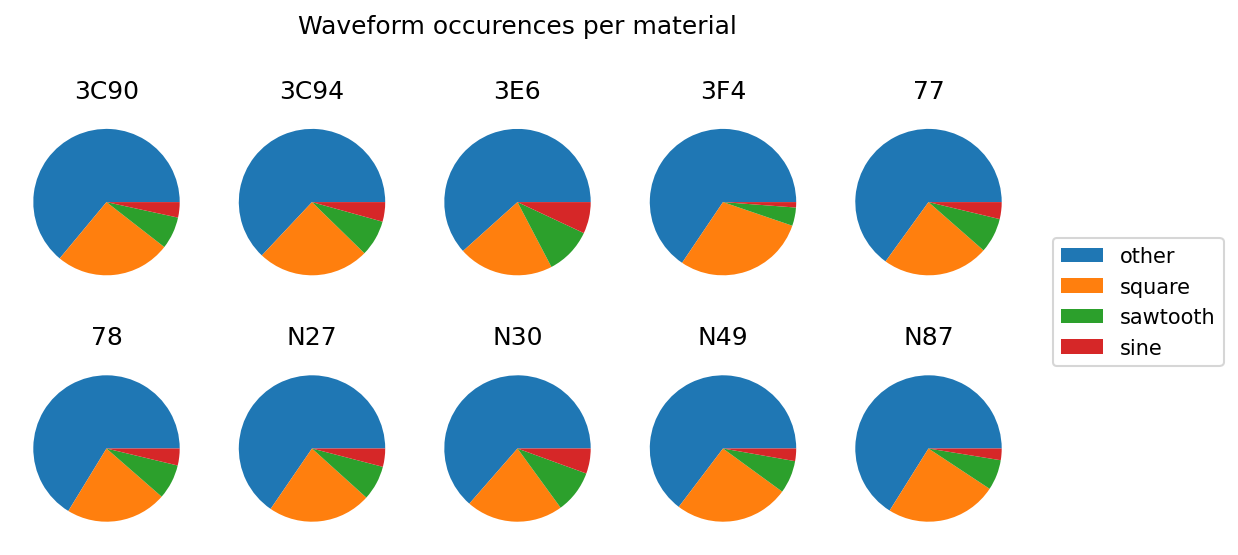

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):

    counts_per_waveform = mat_df['waveform'].value_counts()
    ax.pie(counts_per_waveform.to_numpy().ravel())
    ax.set_title("Waveform occurences")    
    ax.set_title(mat_lbl)

fig.legend(labels=template_lbls, loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle("Waveform occurences per material")
fig.tight_layout()

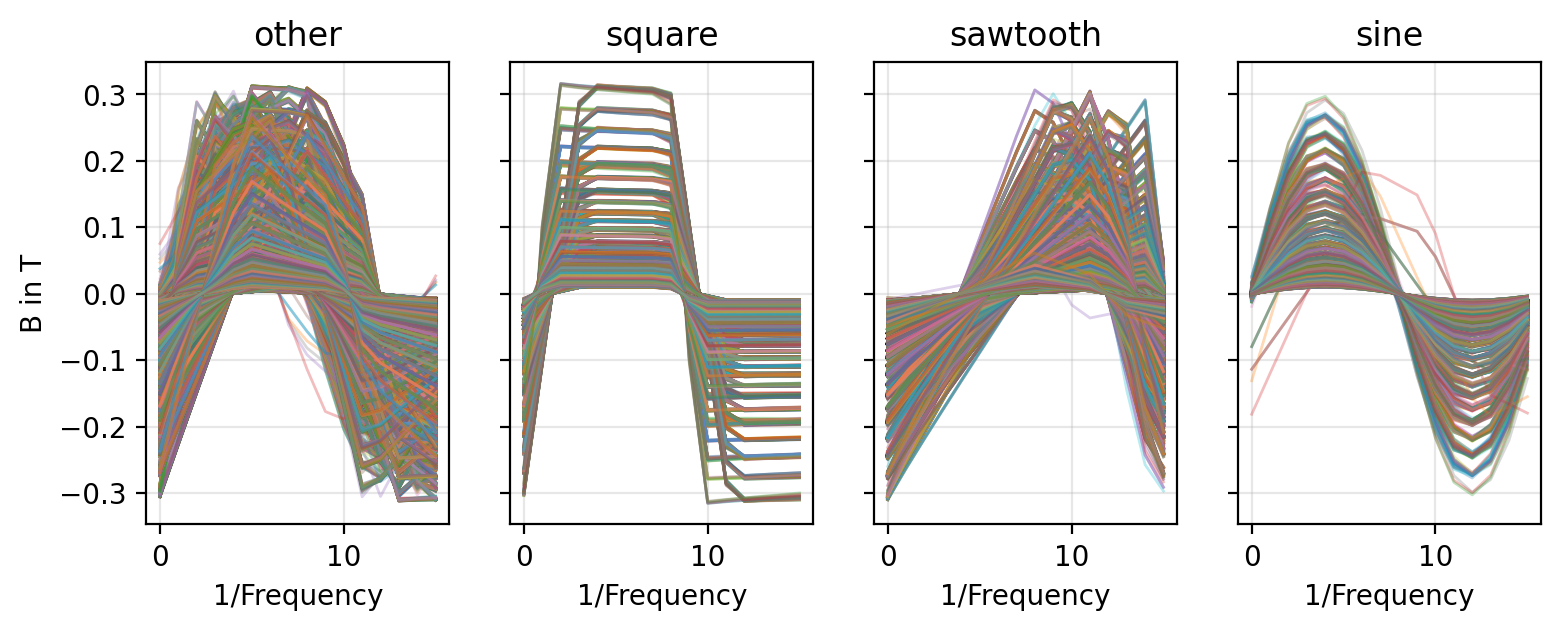

In [41]:
fig, axes = plt.subplots(1, len(template_lbls), dpi=200, figsize=(9, 3), sharex=True, sharey=True)

doi = ds
doi_b = full_b[:, ::64]  # only 16 samples of period
for i, ax in enumerate(axes):
    ax.plot(doi_b[doi.waveform == i, :].T, alpha=0.3, lw=1.0)

axes[0].set_ylabel("B in T")
for ax in axes:
    ax.set_xlabel("1/Frequency")
for i, lbl in enumerate(template_lbls):
    axes[i].set_title(lbl)